## Load documents with IDs

In [3]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [4]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [5]:
len(documents)

948

## Load ground truth

In [6]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [7]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [8]:
len(ground_truth)

1830

In [9]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [10]:
len(doc_idx)

947

In [11]:
doc_idx['5170565b']

{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'section': 'General course-related questions',
 'question': 'What if I miss a session?',
 'course': 'machine-learning-zoomcamp',
 'id': '5170565b'}

## Index data

In [12]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [13]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [14]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

## Retrieval

In [15]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [16]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

## The RAG flow

In [46]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

### openAI setup

In [47]:
!pip install pyyaml

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [48]:
import os

In [49]:
os.getcwd()

'/home/hhammad/Desktop/DTE_LLMs/04_Monitoring/4_3'

In [50]:
import yaml
# Open the file
with open('api_keys.yml', 'r') as file:
    # Load the data from the file
    data = yaml.safe_load(file)
    
# Get the API key (Groq example here)


In [51]:
openai_key

'sk-proj-McHuRUxkVk3XSrO2UAxnT3BlbkFJNq8nDSggzv0oadFo4hTT'

### openAI run

In [52]:
import openai
openai.api_key = openai_key


In [53]:
openai.api_key 

'sk-proj-McHuRUxkVk3XSrO2UAxnT3BlbkFJNq8nDSggzv0oadFo4hTT'

In [54]:
from openai import OpenAI


client = OpenAI(api_key=openai_key)

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [55]:
# previously: rag(query: str) -> str
# dict as we pass question and course
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [56]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [57]:
rag(ground_truth[10])

'Yes, sessions are recorded if you miss one. You will be able to view the recordings and catch up on anything you missed. Additionally, you can ask your questions in advance for office hours, and they will be addressed during the live stream. Moreover, you can always ask questions in Slack.'

In [58]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric

In [59]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

#### embed the two sentence then calculate the cosine between the two vectors with the .dot

In [60]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.7591171

In [61]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [62]:
len(ground_truth)

1830

In [63]:
answers = {}

In [64]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

  0%|          | 0/1830 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [65]:
len(answers)

732

In [66]:
len(answers.items())

732

In [68]:
results_gpt4o = [None] * len(answers.items())

In [69]:
#results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [70]:
import pandas as pd

In [71]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [73]:
df_gpt4o.to_csv('data/hh_results-gpt4o.csv', index=False)

In [79]:
df_gpt4o.sample(n=5)  #.to_dict(orient='records')

,answer_llm,answer_orig,document,question,course
178,To recreate an environment from a saved YAML f...,With regards to creating an environment for th...,32bc0538,What command allows me to recreate an environm...,machine-learning-zoomcamp
486,If your logistic regression model crashes duri...,Fitting the logistic regression takes a long t...,3b3b1989,What should I check if my logistic regression ...,machine-learning-zoomcamp
718,To compute accuracy using the scikit-learn lib...,Model evaluation metrics can be easily compute...,cc53ae94,How can accuracy be computed using scikit lear...,machine-learning-zoomcamp
312,"No, you should not be concerned about using Li...","Yes, you can. We will also do that next week, ...",3f60871d,Should I be concerned about using LinearRegres...,machine-learning-zoomcamp
536,OneHotEncoder and DictVectorizer differ primar...,"Both work in similar ways. That is, to convert...",9ffcc895,How does OneHotEncoder differ from DictVectori...,machine-learning-zoomcamp


In [85]:
df_gpt4o.head(2)

,answer_llm,answer_orig,document,question,course
0,"To sign up for the course, please visit the co...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,"To sign up for the course, you can use the fol...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp


In [88]:
ground_truth[1]['document']

'0227b872'

In [92]:
#doc_idx[ground_truth[1]['document']]

#### cost on https://platform.openai.com/usage

for 40 % of the entire documents

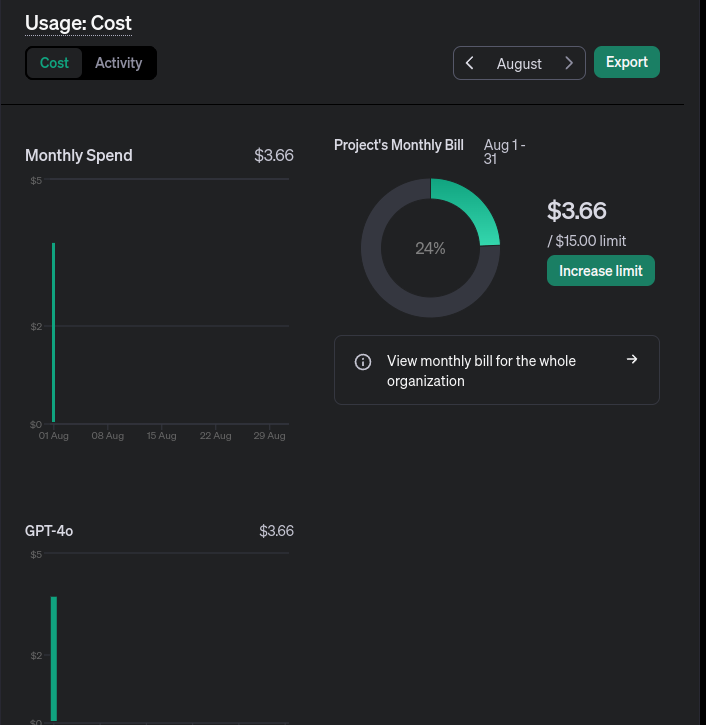

## Evaluating GPT 3.5

In [93]:
rag(ground_truth[10], model='gpt-3.5-turbo')

"No, sessions are recorded so you won't miss anything."

In [100]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=3)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [101]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [102]:
process_record(ground_truth[10])

{'answer_llm': 'No, sessions are recorded so if you miss one, you can still watch it later.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [103]:
results_gpt35 = map_progress(pool, ground_truth, process_record)

  0%|          | 0/1830 [00:00<?, ?it/s]

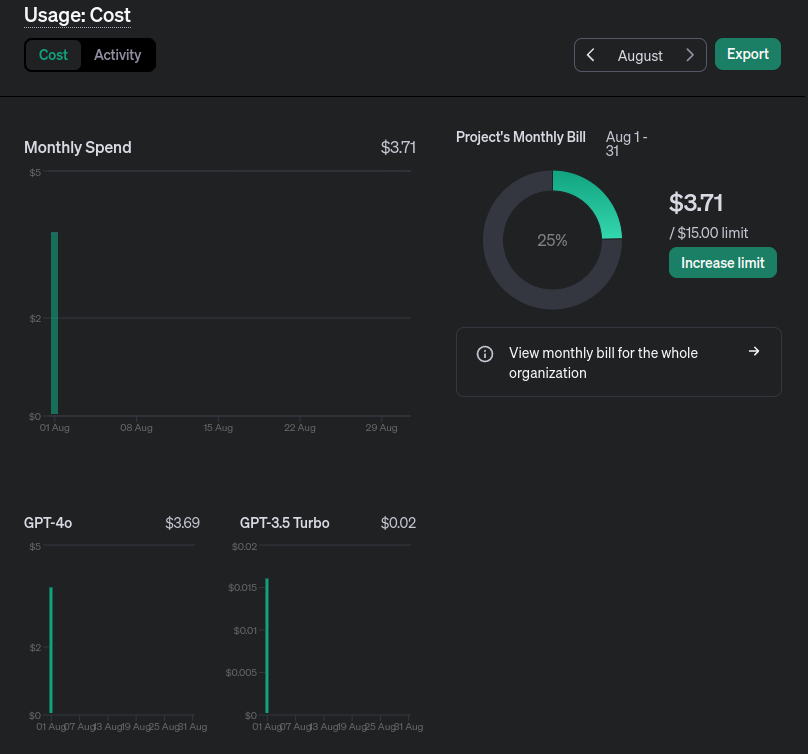

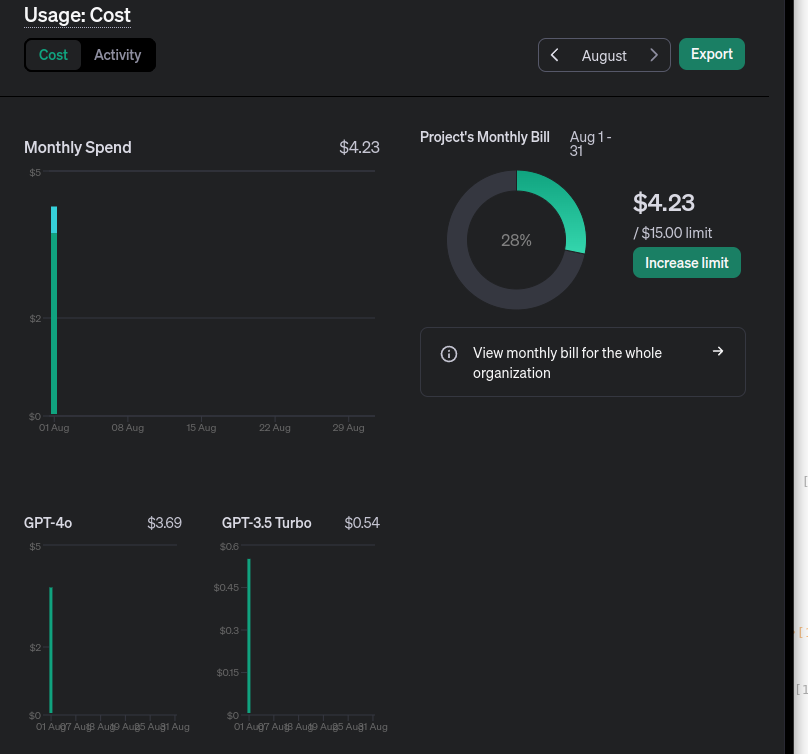

In [105]:
type(results_gpt35)

list

In [106]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/HH_results-gpt35.csv', index=False)

In [125]:
!head data/results-gpt35.csv

answer_llm,answer_orig,document,question,course
You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository thereâ€™s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"I am sorry, but there is no direct link provided in the FAQ database for signing up for the course. However, you can find a link in the course GitHub repository at this address: https://airtable.com/shryxwLd0COOEaqXo.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did thi

## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

### gpt-4o

### gpt-4o

In [104]:
results_gpt4o

[{'answer_llm': 'To sign up for the course, please visit the course page: [http://mlzoomcamp.com/](http://mlzoomcamp.com/). From there, you can scroll down to start accessing and going through the course materials.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 {'answer_llm': "To sign up for the course, you can use the following link provided in the course's GitHub repository: [Sign-Up Link](https://airtable.com/shryxwLd0COOEaqXo).",
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose 

In [124]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [125]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [126]:
record = results_gpt4o[0]

In [129]:
type(results_gpt4o)

list

In [127]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [128]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/732 [00:00<?, ?it/s]

In [110]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    732.000000
mean       0.687674
std        0.200547
min       -0.139294
25%        0.607614
50%        0.732200
75%        0.835239
max        0.988077
Name: cosine, dtype: float64

In [122]:
!pip install  matplotlib




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [123]:
import seaborn as sns



AttributeError: module 'matplotlib' has no attribute 'get_data_path'

### gpt-3.5-turbo

In [146]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [147]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [149]:
import matplotlib.pyplot as plt

### gpt-4o-mini

In [133]:
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [134]:
process_record_4o_mini(ground_truth[10])

{'answer_llm': 'Yes, all sessions are recorded, so if you miss one, you won’t miss anything. You can still ask questions for office hours in advance, and they will be covered during the live stream.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [135]:
results_gpt4omini = []

In [136]:
for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

  0%|          | 0/1830 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [160]:
df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

#### I'll read the file instead

In [142]:
folder_path = '/home/hhammad/Desktop/DTE_LLMs/04_Monitoring/dtc_data'
file_gpt4_mini = 'results-gpt4o-mini.csv'
df_gpt4o_mini = pd.read_csv(os.path.join(folder_path, file_gpt4_mini))

In [143]:
df_gpt4o_mini.shape

(1830, 5)

In [147]:
results_gpt4omini = df_gpt4o_mini.to_dict(orient="records")

In [148]:
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [149]:
len(similarity_4o_mini)

1830

In [150]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

gpt4o 

```
count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64
```

In [151]:
# sns.distplot(df_gpt35['cosine'], label='3.5')

sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

NameError: name 'sns' is not defined

## LLM-as-a-Judge

#### ask gpt for the prompt

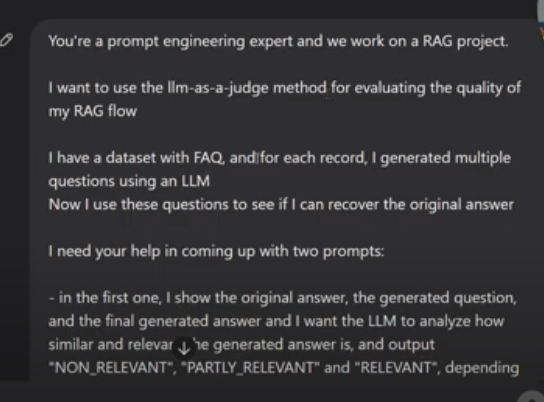


In [153]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [175]:
#prompt1_template

In [154]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [179]:
df_sample.shape, df_sample.head(1)

((150, 6),
                                             answer_llm  \
 726  The syntax for using `precision_recall_fscore_...   
 
                                            answer_orig  document  \
 726  Scikit-learn offers another way: precision_rec...  403bbdd8   
 
                                               question  \
 726  What is the syntax for using precision_recall_...   
 
                         course    cosine  
 726  machine-learning-zoomcamp  0.901076  )

In [155]:
samples = df_sample.to_dict(orient='records')

In [180]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.9010756015777588}

In [181]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [182]:
answer = llm(prompt, model='gpt-4o-mini')

In [183]:
answer

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer directly addresses the question about the syntax for using `precision_recall_fscore_support` in Python by providing the exact code snippet from the original answer. It maintains the context and aligns well with the provided information."\n}'

In [159]:
import json

In [160]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [184]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [185]:
len(json_evaluations)

150

In [188]:
df_evaluations = pd.DataFrame(json_evaluations)

In [189]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           124
PARTLY_RELEVANT     16
NON_RELEVANT        10
Name: count, dtype: int64

In [190]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer discusses a pip version e...
11,NON_RELEVANT,The generated answer addresses a different err...
27,NON_RELEVANT,The generated answer incorrectly states that t...
41,NON_RELEVANT,The generated answer does not relate to the or...
45,NON_RELEVANT,The generated answer incorrectly states that t...
90,NON_RELEVANT,The generated answer addresses a different que...
93,NON_RELEVANT,The generated answer does not address the cont...
116,NON_RELEVANT,The generated answer does not relate to the or...
138,NON_RELEVANT,The generated answer addresses a different pro...
139,NON_RELEVANT,The generated answer discusses the requirement...


In [196]:
samples[4]

{'answer_llm': "The cause of the pip version error in this week's serverless deep learning section could be a version conflict in Scikit-Learn. Specifically, if you are using a different version than what was used during the model training, it can lead to warnings and potential breaking code or invalid results. To resolve this, make sure to use the same version of Scikit-Learn that was used for training the model. For instance, if you trained with version 1.1.1, you should use that same version in your virtual environment.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://github.com/alexeygrigorev/tflite-aws-lambda/raw

In [194]:
#df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

In [197]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
```

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}


In [198]:
evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question by providing the correct syntax for using the `precision_recall_fscore_support` function in Python, along with a relevant code example."
}


In [199]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_2.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [200]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [201]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [202]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
45,NON_RELEVANT,The generated answer explicitly states that it...
49,NON_RELEVANT,The generated answer does not address the ques...
102,NON_RELEVANT,The generated answer does not address the core...


In [203]:
samples[45]

{'answer_llm': 'The provided context does not include specific commands to start the Docker daemon on Linux. Therefore, I cannot provide an answer based solely on the facts from the context.',
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of these commands:\nsudo dockerd\nsudo service docker start\nAdded by Ugochukwu Onyebuchi',
 'document': '4b2a3181',
 'question': 'What commands should I use to start the docker daemon on Linux?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.5113022327423096}

## Saving all the data

In [204]:
df_gpt4o.to_csv('data/hh_results-gpt4o-cosine.csv', index=False)
df_gpt35.to_csv('data/hh_results-gpt35-cosine.csv', index=False)
df_gpt4o_mini.to_csv('data/hh_results-gpt4o-mini-cosine.csv', index=False)

In [205]:
df_evaluations.to_csv('data/hh_evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/hh_evaluations-qa.csv', index=False)

# Homework

## Getting the data

In [1]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '04-monitoring/data/results-gpt4o-mini.csv'
generated_gpt4_mini = f'{base_url}/{relative_url}?raw=1'

df = pd.read_csv(generated_gpt4_mini)
#df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
#ground_truth = df_ground_truth.to_dict(orient='records')

In [2]:
df = df.iloc[:300]

In [3]:
df.shape

(300, 5)

## Q1. Getting the embeddings model

In [4]:
model_name = "multi-qa-mpnet-base-dot-v1"

In [6]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name)

In [7]:
df.columns

Index(['answer_llm', 'answer_orig', 'document', 'question', 'course'], dtype='object')

In [8]:
answer_llm = df.iloc[0].answer_llm


In [9]:
answer_llm

'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).'

In [10]:
v_llm = embedding_model.encode(answer_llm)


In [11]:
v_llm

array([-4.22446787e-01, -2.24855945e-01, -3.24058473e-01, -2.84758747e-01,
        7.25685246e-03,  1.01186700e-01,  1.03716828e-01, -1.89983383e-01,
       -2.80596819e-02,  2.71588862e-01, -1.15337133e-01,  1.14666067e-01,
       -8.49587619e-02,  3.32365334e-01,  5.52725159e-02, -2.22195953e-01,
       -1.42540991e-01,  1.02519318e-01, -1.52333513e-01, -2.02912480e-01,
        1.98424123e-02,  8.38148072e-02, -5.68632185e-01,  2.32843738e-02,
       -1.67292967e-01, -2.39256978e-01, -8.05461779e-02,  2.57081706e-02,
       -8.15464854e-02, -7.39289895e-02, -2.61550128e-01,  1.92576721e-02,
        3.22909206e-01,  1.90357178e-01, -9.34726413e-05, -2.13165879e-01,
        2.88942400e-02, -1.79529544e-02, -5.92760742e-02,  1.99918360e-01,
       -4.75170761e-02,  1.71634018e-01, -2.45914217e-02, -9.38058272e-02,
       -3.57002944e-01,  1.33263648e-01,  1.94046125e-01, -1.18530720e-01,
        4.56915259e-01,  1.47728026e-01,  3.35945129e-01, -1.86959922e-01,
        2.45954573e-01, -

In [12]:

v_orig = embedding_model.encode(df.iloc[0].answer_orig)

v_llm.dot(v_orig)

17.515997

## Q2. Computing the dot product

In [13]:
results_gpt4omini_list = df.to_dict(orient="records")
results_gpt4omini_list

[{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 {'answer_llm': 'You can sign up using the link provided in the course GitHub repository: [https://airtable.com/shryxwLd0COOEaqXo](https://airtable.com/shryxwLd0COOEaqXo).',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our

In [14]:
results_gpt4omini_list[0]['answer_llm']

'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).'

In [15]:
df.columns

Index(['answer_llm', 'answer_orig', 'document', 'question', 'course'], dtype='object')

In [16]:
from tqdm.auto import tqdm


In [17]:
evaluations = []

for record in tqdm(results_gpt4omini_list):
    v_llm = embedding_model.encode(record['answer_llm'])
    v_orig = embedding_model.encode(record['answer_orig'])
    dp = v_llm.dot(v_orig)
    evaluations.append(dp) #dotproduct = compute_similarity(record)
    

  0%|          | 0/300 [00:00<?, ?it/s]

In [18]:
df_evaluations= pd.DataFrame()
df_evaluations['score'] = evaluations

In [19]:
df_evaluations.describe()

,score
count,300.000000
mean,27.495996
std,6.384743
min,4.547926
25%,24.307844
50%,28.336861
75%,31.674304
max,39.476013


## Q3. Computing the cosine

In [24]:
import numpy as np

In [25]:
def normalizing(v):
    norm = np.sqrt((v * v).sum())
    v_norm = v / norm
    return v_norm
    

In [26]:
normalizing(v_llm)

array([-2.11306959e-02, -1.53223593e-02, -3.43620703e-02,  1.98937692e-02,
        2.64813774e-04, -2.77096275e-02, -1.63180511e-02,  3.27728651e-02,
        1.02764834e-02,  4.32049185e-02,  2.97470968e-02, -1.64741985e-02,
        4.28259596e-02,  8.87097139e-03,  2.40928703e-03, -4.06071218e-03,
       -2.75038555e-02,  2.57525593e-02, -6.17438108e-02,  1.62241049e-02,
       -3.53289098e-02,  5.32247871e-02,  5.25180344e-03,  2.28471104e-02,
        3.92429205e-03,  1.27627961e-02,  1.35364877e-02,  7.77296051e-02,
       -3.22006419e-02, -6.01691008e-02, -1.34758176e-02,  1.85390767e-02,
       -1.31161604e-03,  2.39917058e-02, -1.60573945e-05, -1.42468023e-03,
        9.87560004e-02, -1.14630526e-02, -3.72214094e-02, -3.54782380e-02,
       -5.72972447e-02, -4.96582240e-02, -2.75296974e-03, -4.27222028e-02,
        5.11458032e-02,  1.45730404e-02,  4.68182117e-02,  3.17602456e-02,
        5.42251505e-02,  4.59975377e-02,  5.68841100e-02,  1.83609016e-02,
        2.98353862e-02, -

In [27]:
evaluations

[17.515997,
 13.4184065,
 25.31325,
 12.147419,
 18.747728,
 33.970398,
 30.251701,
 29.521585,
 35.2722,
 27.751759,
 32.34471,
 31.441847,
 36.38073,
 33.340515,
 30.606163,
 32.503044,
 29.674446,
 24.353462,
 20.13246,
 23.995468,
 30.880272,
 32.692432,
 30.049168,
 16.078167,
 31.796417,
 37.98001,
 20.839043,
 32.612854,
 38.894203,
 34.051826,
 28.26388,
 27.124832,
 23.975266,
 26.34014,
 18.658117,
 25.016396,
 21.101133,
 33.726788,
 29.340345,
 28.65449,
 29.608582,
 30.810736,
 33.3312,
 26.220486,
 26.550077,
 13.148602,
 12.962549,
 12.275612,
 9.974444,
 10.883927,
 29.84507,
 32.36179,
 22.187178,
 30.268929,
 25.091877,
 32.742783,
 28.22099,
 27.274975,
 24.208641,
 22.568905,
 19.767452,
 18.679333,
 20.422318,
 22.051323,
 18.188011,
 28.455889,
 25.919704,
 23.332329,
 22.205935,
 28.296305,
 39.23055,
 36.758514,
 31.913893,
 31.202858,
 36.91305,
 30.514198,
 36.261467,
 27.397549,
 37.7928,
 23.297688,
 34.25258,
 34.550613,
 30.316456,
 35.70352,
 31.012527,
 

In [28]:
evaluations_q3 = []

for record in tqdm(results_gpt4omini_list):
    v_llm = embedding_model.encode(record['answer_llm'])
    v_orig = embedding_model.encode(record['answer_orig'])
    #dp = v_llm.dot(v_orig)
    n_v_llm= normalizing(v_llm)
    n_v_orig= normalizing(v_orig) 
    dp2 = n_v_llm.dot(n_v_orig)
    evaluations_q3.append(dp2) #dotproduct = compute_similarity(record)

  0%|          | 0/300 [00:00<?, ?it/s]

In [29]:
type(evaluations_q3)

list

In [30]:
df_evaluations_q3= pd.DataFrame()
df_evaluations_q3['normalized_score'] = evaluations_q3

In [32]:
df_evaluations_q3.describe()

,normalized_score
count,300.000000
mean,0.728392
std,0.157755
min,0.125357
25%,0.651273
50%,0.763761
75%,0.836235
max,0.958796


## Q4. Rouge

In [33]:
#!pip install rouge


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [35]:
r = results_gpt4omini_list[10]
r

{'answer_llm': "Yes, all sessions are recorded, so if you miss one, you won't miss anything. You can catch up on the content later. Additionally, you can submit your questions in advance for office hours, and those sessions are also recorded.",
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [36]:
from rouge import Rouge
rouge_scorer = Rouge()

scores = rouge_scorer.get_scores(r['answer_llm'], r['answer_orig'])[0]

In [37]:
scores

{'rouge-1': {'r': 0.45454545454545453,
  'p': 0.45454545454545453,
  'f': 0.45454544954545456},
 'rouge-2': {'r': 0.21621621621621623,
  'p': 0.21621621621621623,
  'f': 0.21621621121621637},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3939393939393939,
  'f': 0.393939388939394}}

#### What's the F score for rouge-1?

 'f': 0.45454544954545456},

## Q5. Average rouge score

In [ ]:
average_F_score = scores['rouge1']

In [39]:
scores['rouge-1']['f']

0.45454544954545456

In [49]:
fscores = [scores[k]['f'] for k in scores.keys() ]

In [50]:
fscores

[0.45454544954545456, 0.21621621121621637, 0.393939388939394]

In [51]:
average_f_score = sum(fscores)/len(fscores)

In [52]:
average_f_score

0.35490034990035496

## Q6. Average rouge score for all the data points

In [53]:
rouge_scores = []


for record in tqdm(results_gpt4omini_list):
   #v_llm = embedding_model.encode(record['answer_llm'])
    #v_orig = embedding_model.encode(record['answer_orig'])

    rouge_score = rouge_scorer.get_scores(record['answer_llm'], record['answer_orig'])[0]
    rouge_scores.append(rouge_score)
    #dp = v_llm.dot(v_orig)
    #n_v_llm= normalizing(v_llm)
    #n_v_orig= normalizing(v_orig) 
    #dp2 = n_v_llm.dot(n_v_orig)
    #evaluations_q3.append(dp2) #dotproduct = compute_similarity(record)

  0%|          | 0/300 [00:00<?, ?it/s]

In [56]:
len(rouge_scores), rouge_scores

(300,
 [{'rouge-1': {'r': 0.061224489795918366,
    'p': 0.21428571428571427,
    'f': 0.09523809178130524},
   'rouge-2': {'r': 0.017543859649122806,
    'p': 0.07142857142857142,
    'f': 0.028169010918468917},
   'rouge-l': {'r': 0.061224489795918366,
    'p': 0.21428571428571427,
    'f': 0.09523809178130524}},
  {'rouge-1': {'r': 0.08163265306122448,
    'p': 0.26666666666666666,
    'f': 0.12499999641113292},
   'rouge-2': {'r': 0.03508771929824561,
    'p': 0.13333333333333333,
    'f': 0.05555555225694465},
   'rouge-l': {'r': 0.061224489795918366, 'p': 0.2, 'f': 0.09374999641113295}},
  {'rouge-1': {'r': 0.32653061224489793,
    'p': 0.5714285714285714,
    'f': 0.41558441095631643},
   'rouge-2': {'r': 0.14035087719298245,
    'p': 0.24242424242424243,
    'f': 0.17777777313333343},
   'rouge-l': {'r': 0.30612244897959184,
    'p': 0.5357142857142857,
    'f': 0.3896103849822905}},
  {'rouge-1': {'r': 0.16326530612244897, 'p': 0.32, 'f': 0.2162162117421476},
   'rouge-2': {'r

In [58]:
rouge_scores_dict = {}
for i in range(len(rouge_scores)):
    rouge_scores_dict[i]= rouge_scores[i]

type(rouge_scores_dict)

dict

In [60]:
rouge_scores_dict[0]

{'rouge-1': {'r': 0.061224489795918366,
  'p': 0.21428571428571427,
  'f': 0.09523809178130524},
 'rouge-2': {'r': 0.017543859649122806,
  'p': 0.07142857142857142,
  'f': 0.028169010918468917},
 'rouge-l': {'r': 0.061224489795918366,
  'p': 0.21428571428571427,
  'f': 0.09523809178130524}}

In [61]:

rouge_scores_df = pd.DataFrame.from_dict(rouge_scores_dict, orient='index')


In [62]:
rouge_scores_df

,rouge-1,rouge-2,rouge-l
0,"{'r': 0.061224489795918366, 'p': 0.21428571428...","{'r': 0.017543859649122806, 'p': 0.07142857142...","{'r': 0.061224489795918366, 'p': 0.21428571428..."
1,"{'r': 0.08163265306122448, 'p': 0.266666666666...","{'r': 0.03508771929824561, 'p': 0.133333333333...","{'r': 0.061224489795918366, 'p': 0.2, 'f': 0.0..."
2,"{'r': 0.32653061224489793, 'p': 0.571428571428...","{'r': 0.14035087719298245, 'p': 0.242424242424...","{'r': 0.30612244897959184, 'p': 0.535714285714..."
3,"{'r': 0.16326530612244897, 'p': 0.32, 'f': 0.2...","{'r': 0.03508771929824561, 'p': 0.071428571428...","{'r': 0.14285714285714285, 'p': 0.28, 'f': 0.1..."
4,"{'r': 0.2653061224489796, 'p': 0.0970149253731...","{'r': 0.07017543859649122, 'p': 0.022346368715...","{'r': 0.22448979591836735, 'p': 0.082089552238..."
...,...,...,...
295,"{'r': 0.6428571428571429, 'p': 0.6666666666666...","{'r': 0.559322033898305, 'p': 0.52380952380952...","{'r': 0.6071428571428571, 'p': 0.6296296296296..."
296,"{'r': 0.6428571428571429, 'p': 0.5454545454545...","{'r': 0.5423728813559322, 'p': 0.4, 'f': 0.460...","{'r': 0.6071428571428571, 'p': 0.5151515151515..."
297,"{'r': 0.6607142857142857, 'p': 0.6491228070175...","{'r': 0.5932203389830508, 'p': 0.5384615384615...","{'r': 0.6428571428571429, 'p': 0.6315789473684..."
298,"{'r': 0.2857142857142857, 'p': 0.3265306122448...","{'r': 0.13559322033898305, 'p': 0.129032258064...","{'r': 0.2857142857142857, 'p': 0.3265306122448..."


In [69]:
rouge2 = rouge_scores_df['rouge-2'].apply(pd.Series)

In [70]:
rouge2.describe()

,r,p,f
count,300.000000,300.000000,300.000000
mean,0.198613,0.258626,0.206965
std,0.164964,0.174559,0.153550
min,0.000000,0.000000,0.000000
25%,0.074632,0.138093,0.097809
50%,0.159075,0.230769,0.178671
75%,0.260995,0.335366,0.286181
max,0.805556,1.000000,0.739130


In [71]:
average_r = rouge2['r'].mean()
average_p = rouge2['p'].mean()
average_f = rouge2['f'].mean()
average_r, average_p, average_f

(0.19861258009846788, 0.25862646516998544, 0.20696501983423318)